In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
import nltk
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from wordcloud import WordCloud
import os

In [4]:
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [61]:
def tf_idf_vectorizer(facts_df):
    # Vectorise
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    # Matrix of vectors that will be used to train KMeans
    matrix = vectorizer.fit_transform(facts_df['Facts'])

    return vectorizer, matrix


# (Mainly for experiments) Used to understand inertia without first applying dimensionality reduction
def calculate_inertia(facts_df, end, step):
    # tf-idf
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.20, ngram_range=(2, 2))
    matrix = vectorizer.fit_transform(facts_df['Facts'])

    # save k-means inertia for each K used to train the model
    inertia_list = []
    for k in range(1, end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)
        inertia_list.append(kmeans.inertia_)

    return inertia_list


def k_means_clustering(X_svd, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit(X_svd)
    return clusters


# This function is to calculate inertia when SVD is applied, inertia_list used for plotting
def calc_inertia_svd(X_svd, end, step):
    inertia_list = []
    for k in range(1, end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_svd)
        inertia_list.append(kmeans.inertia_)

    return inertia_list


# This function is to plot the scatter plots of Violation/Non-Violation processed facts
def view_k_means(facts_df, kmeans, tf_idf_matrix, vectorizer):
    kmeans.fit(tf_idf_matrix)
    clusters = kmeans.labels_

    # Visualisation
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(tf_idf_matrix.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    facts_df['Cluster'] = clusters
    facts_df['x0'] = x0
    facts_df['x1'] = x1

    # getting the top keywords
    top_words = pd.DataFrame(tf_idf_matrix.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names_out()
    for i, r in top_words.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-10:]]))

    cluster_map = {0: 'Private Life',
                   1: 'Injury',
                   2: 'Prisoner',
                   3: 'Confinement',
                   4: 'Defamation',
                   5: 'Cluster 6',
                   6: 'Cluster 7',
                   7: 'Cluster 8'}

    facts_df['Cluster'] = facts_df['Cluster'].map(cluster_map)
    cluster_centers = kmeans.cluster_centers_
    # set image size
    plt.figure(figsize=(12, 7))
    # set a title
    plt.title("Processed Facts regarding Dignity - Document clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=facts_df, x='x0', y='x1', hue='Cluster', palette="Paired", s=50)
    # TRIAL
    plt.scatter(centroids_trial[:,0] , centroids_trial[:,1] , s = 80, color = 'k')

    '''
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_
    # Calculate distances from data points to cluster centers
    distances = pairwise_distances(tf_idf_matrix, cluster_centers, metric='euclidean')
    # Get the index of the closest cluster center for each data point
    closest_cluster_indices = np.argmin(distances, axis=1)
    # Add a new column 'ClosestCentroid' to facts_df
    facts_df['ClosestCentroid'] = closest_cluster_indices

    # Show the data points closest to each centroid
    for i in range(len(cluster_centers)):
        closest_points = facts_df[facts_df['ClosestCentroid'] == i]
        print(f"\nData points closest to Centroid {i}:")
        print(closest_points)

    # Get the top three data points closest to each centroid
    top_three_indices = np.argsort(distances, axis=0)[:3]
    top_three_data_points = [facts_df[facts_df['ClosestCentroid'] == i].iloc[top_three_indices[:, i]] for i in
                             range(len(cluster_centers))]

    # Show the top three data points closest to each centroid
    for i in range(len(cluster_centers)):
        print(f"\nTop three data points closest to Centroid {i}:")
        print(top_three_data_points[i])
    '''
    plt.show()

    return facts_df, cluster_centers


def word_cloud_generator(X, in_X_tfidf, k, in_word_positions):
    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        #plt.show()
        if not os.path.exists('wordclouds'):
            os.makedirs('wordclouds')
        plt.savefig(f"wordclouds/cloud {in_cluster_id}.png")

    return in_cluster_ids, in_model

def remove_lang_words(facts_words, english_words):
    # Filtering out non-english words and three-letter words
    filtered = [word for word in facts_words if word in english_words and len(word) > 3]
    return filtered

In [66]:
from google.colab import files
import io

In [7]:
uploaded = files.upload()

Saving facts_processed.csv to facts_processed.csv


In [67]:
uploaded = files.upload()

Saving dignity_cases.csv to dignity_cases (2).csv


In [12]:
all_processed_facts = pd.read_csv(io.BytesIO(uploaded['facts_processed.csv']))

In [68]:
dignity_cases = pd.read_csv(io.BytesIO(uploaded['dignity_cases (2).csv']))

In [56]:
new_facts = pd.DataFrame(columns=['Facts'])
english_words = set(nltk.corpus.words.words())

In [57]:
for fact in all_processed_facts['Facts']:
    fact_words = fact.split()
    facts_words_filtered = remove_lang_words(fact_words, english_words)
    new_fact = ' '.join(facts_words_filtered)
    new_row = pd.DataFrame({'Facts': [new_fact]})
    new_facts = pd.concat([new_facts, new_row], ignore_index=True)


In [58]:
# Dimensionality reduction applied by means of Singular value decomposition
vectorizer, tfidf_matrix = tf_idf_vectorizer(new_facts)
svd = TruncatedSVD(n_components=500, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.75


In [ ]:
# Calculating the Inertia
warnings.filterwarnings('ignore')
inertia_list = calc_inertia_svd(X_svd, 20, 1)
plt.plot(range(1, 20, 1), inertia_list)
plt.scatter(range(1, 20, 1), inertia_list)
plt.scatter(8, inertia_list[8], marker="X", s=300, c="r")

plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

In [ ]:
# Wordclouds
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids, kmeans = word_cloud_generator(X_svd, tfidf_matrix, 8, word_positions)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 0
chamber,measure,interference,would,member,protection,social,majority,constitutional,child

Cluster 1
taken,provision,procedure,damage,constitutional,protection,would,code,whether,investigation

Cluster 2
name,degrading,rate,affront,disclose,confinement,table,courtroom,metal,cage

Cluster 3
migration,detention,removal,migrant,deportation,expulsion,immigration,alien,refugee,asylum

Cluster 4
force,arrest,investigator,bruise,forensic,station,medical,investigation,officer,injury

Cluster 5
treatment,toilet,facility,prisoner,space,condition,inmate,prison,detention,cell

Cluster 6
disease,health,diagnosis,care,prison,treatment,doctor,detention,hospital,medical

Cluster 7
criticism,press,statement,debate,publication,interference,newspaper,journalist,defamation,reputation


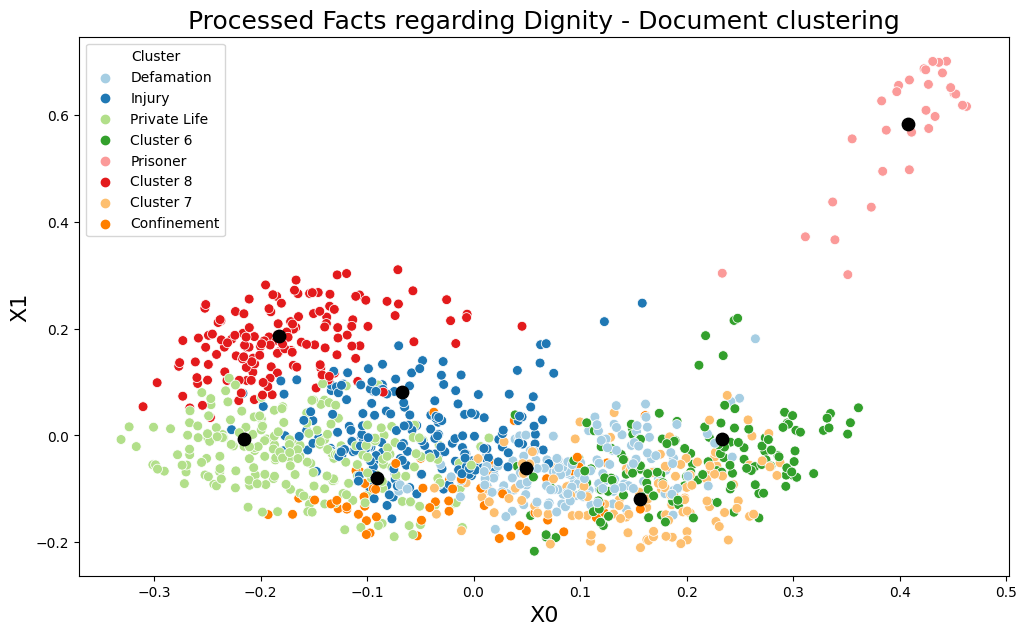

In [62]:
facts_df_updated, cluster_centers = view_k_means(all_processed_facts, kmeans, tfidf_matrix, vectorizer)

In [ ]:
print('Cluster Centers')
print(cluster_centers)
print(cluster_centers[0])
print(len(cluster_centers[0]))
print(cluster_centers[2])
print(len(cluster_centers[2]))

print(facts_df_updated)

In [23]:
array = kmeans.labels_

In [24]:
facts_df_updated['Label'] = array

In [26]:
facts_df_updated.head(20)

,Unnamed: 0,Facts,Cluster,x0,x1,Label
0,0,born life vilnius around motorcycle collided c...,Defamation,0.012122,-0.037384,4
1,1,introduction lived worked farmer village kuşko...,Injury,-0.017024,-0.048012,1
2,2,detail concerning found annex background oliar...,Private Life,-0.250659,-0.042900,0
3,3,born life râmnicu vâlcea pretrial detention ag...,Injury,0.058007,0.002193,1
4,4,born life louvencourt hired french national ra...,Injury,-0.092904,0.037815,1
5,5,born currently detained iaşi prison detained p...,Cluster 6,0.273406,-0.029222,5
6,6,born life shropshire severely disabled result ...,Private Life,-0.049482,-0.072821,0
7,7,born life warsaw submitted party summarised ar...,Defamation,0.159606,-0.085814,4
8,8,information relevant set appended table compla...,Prisoner,0.443998,0.700277,2
9,9,born life dubrovnik incident around dubrovnik ...,Injury,-0.000901,-0.060950,1


Trying another scatterplot

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(2)

In [34]:
trial_df = pca.fit_transform(tfidf_matrix.toarray())

In [35]:
trial_df.shape

(1113, 2)

In [42]:
print(trial_df)

[[ 0.01212219 -0.03738398]
 [-0.01702446 -0.04801399]
 [-0.25065954 -0.04289975]
 ...
 [-0.09960949 -0.04060738]
 [-0.21581122  0.14718212]
 [ 0.16903696 -0.11301012]]


In [70]:
trial_df[:,0]

array([ 0.01212219, -0.01702446, -0.25065954, ..., -0.09960949,
       -0.21581122,  0.16903696])

In [38]:
# Applying Kmeans
kmeans_trial = KMeans(8)
label_trial = kmeans_trial.fit_predict(trial_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [110]:
clusters = kmeans_trial.labels_
print(clusters)

[0 0 1 ... 3 4 6]


In [39]:
print(label_trial)

[0 0 1 ... 3 4 6]


In [45]:
unique_labels = np.unique(label_trial)
print(unique_labels)

[0 1 2 3 4 5 6 7]


In [111]:
# getting the top keywords
top_words = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
terms = vectorizer.get_feature_names_out()
for i, r in top_words.iterrows():
  print('\nCluster {}'.format(i))
  print(','.join([terms[t] for t in np.argsort(r)[-10:]]))


Cluster 0
arrest,whether,taken,report,injury,detention,treatment,medical,investigation,officer

Cluster 1
margin,opinion,political,constitution,interference,protection,member,chamber,majority,constitutional

Cluster 2
name,degrading,rate,affront,disclose,confinement,table,courtroom,metal,cage

Cluster 3
international,parent,life,whether,member,measure,would,family,protection,child

Cluster 4
criticism,statement,press,debate,publication,interference,newspaper,journalist,defamation,reputation

Cluster 5
provision,cost,code,rate,protection,would,damage,constitutional,whether,interference

Cluster 6
hospital,inmate,facility,doctor,treatment,prisoner,cell,medical,prison,detention

Cluster 7
facility,inhuman,rate,degrading,condition,medical,treatment,prison,cell,detention


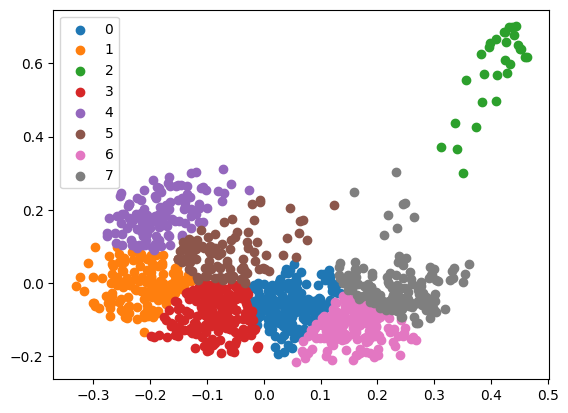

In [46]:
for i in unique_labels:
  plt.scatter(trial_df[label_trial == i][:,0], trial_df[label_trial == i][:,1], label = i)

plt.legend()
plt.show()

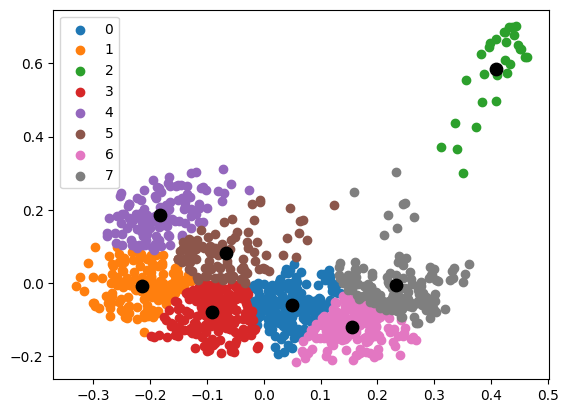

In [48]:
centroids_trial = kmeans_trial.cluster_centers_
for i in unique_labels:
    plt.scatter(trial_df[label_trial == i][:,0], trial_df[label_trial == i][:,1], label = i)
plt.scatter(centroids_trial[:,0] , centroids_trial[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [63]:
print(centroids_trial[:,0])

[ 0.04897714 -0.21503839  0.40806249 -0.09049082 -0.18245257 -0.06695329
  0.15601113  0.23290869]


In [74]:
print(centroids_trial[:,1])

[-0.06098129 -0.00680767  0.5836278  -0.07898263  0.18564303  0.08155138
 -0.11952805 -0.00610871]


In [71]:
print(centroids_trial[0,0])

0.04897714313337977


In [72]:
overall_df = pd.DataFrame(columns = ['Case', 'Facts', 'PCA1', 'PCA2', 'Cluster', 'Center1', 'Center2'])
overall_df['Case'] = dignity_cases['Case']
overall_df['Facts'] = all_processed_facts['Facts']
overall_df['PCA1'] = trial_df[:,0]
overall_df['PCA2'] = trial_df[:,1]
overall_df['Cluster'] = label_trial

array_center_1 = []
array_center_2 = []
for lab in overall_df['Cluster']:
  array_center_1.append(centroids_trial[lab,0])
  array_center_2.append(centroids_trial[lab,1])

overall_df['Center1'] = array_center_1
overall_df['Center2'] = array_center_2

In [73]:
overall_df.head(10)

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048977,-0.060981
1,001-128036.txt,introduction lived worked farmer village kuşko...,-0.017024,-0.048014,0,0.048977,-0.060981
2,001-156265.txt,detail concerning found annex background oliar...,-0.250660,-0.042900,1,-0.215038,-0.006808
3,001-126972.txt,born life râmnicu vâlcea pretrial detention ag...,0.058007,0.002193,0,0.048977,-0.060981
4,001-181273.txt,born life louvencourt hired french national ra...,-0.092904,0.037815,5,-0.066953,0.081551
5,001-145225.txt,born currently detained iaşi prison detained p...,0.273406,-0.029221,7,0.232909,-0.006109
6,001-127107.txt,born life shropshire severely disabled result ...,-0.049483,-0.072820,3,-0.090491,-0.078983
7,001-195992.txt,born life warsaw submitted party summarised ar...,0.159606,-0.085813,6,0.156011,-0.119528
8,001-221519.txt,information relevant set appended table compla...,0.443998,0.700278,2,0.408062,0.583628
9,001-145741.txt,born life dubrovnik incident around dubrovnik ...,-0.000901,-0.060949,0,0.048977,-0.060981


In [76]:
# example of finding the eucledian distance
a = np.array([centroids_trial[0,0], centroids_trial[0,1]])
b = np.array([trial_df[0,0], trial_df[0,1]])
dist = np.linalg.norm(a-b)

print(a)
print(b)
print(dist)

[ 0.04897714 -0.06098129]
[ 0.01212219 -0.03738398]
0.0437620904271725


In [89]:
distances = []
for i in range(len(overall_df['Case'])):
  a = np.array([overall_df['Center1'].loc[[i]], overall_df['Center2'].loc[[i]]])
  b = np.array([overall_df['PCA1'].loc[[i]], overall_df['PCA2'].loc[[i]]])
  dist = np.linalg.norm(a-b)
  distances.append(dist)

overall_df['Dist'] = distances
overall_df.head(10)

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048977,-0.060981,0.043762
1,001-128036.txt,introduction lived worked farmer village kuşko...,-0.017024,-0.048014,0,0.048977,-0.060981,0.067263
2,001-156265.txt,detail concerning found annex background oliar...,-0.250660,-0.042900,1,-0.215038,-0.006808,0.050710
3,001-126972.txt,born life râmnicu vâlcea pretrial detention ag...,0.058007,0.002193,0,0.048977,-0.060981,0.063817
4,001-181273.txt,born life louvencourt hired french national ra...,-0.092904,0.037815,5,-0.066953,0.081551,0.050856
5,001-145225.txt,born currently detained iaşi prison detained p...,0.273406,-0.029221,7,0.232909,-0.006109,0.046628
6,001-127107.txt,born life shropshire severely disabled result ...,-0.049483,-0.072820,3,-0.090491,-0.078983,0.041469
7,001-195992.txt,born life warsaw submitted party summarised ar...,0.159606,-0.085813,6,0.156011,-0.119528,0.033906
8,001-221519.txt,information relevant set appended table compla...,0.443998,0.700278,2,0.408062,0.583628,0.122060
9,001-145741.txt,born life dubrovnik incident around dubrovnik ...,-0.000901,-0.060949,0,0.048977,-0.060981,0.049878


In [92]:
# Checking how many cases are in each cluster
overall_df['Cluster'].value_counts()

0    202
3    199
6    167
1    143
7    137
4    131
5    105
2     29
Name: Cluster, dtype: int64

In [99]:
closest_array = []
closest = 100
for lab in range(8):
  for i in range(len(overall_df['Case'])):
    if overall_df.loc[i, 'Cluster'] == lab:
      dist = overall_df.loc[i, 'Dist']
      if dist < closest:
        closest = dist
  closest_array.append(closest)
  closest = 100

print(closest_array)

[0.0035552821873281234, 0.011853856566479172, 0.016471195677650412, 0.005498509462878366, 0.0030639051266640187, 0.00751037066960461, 0.0039059246867327643, 0.002077138579261941]


In [101]:
represent = []

for i in range(len(overall_df['Case'])):
  if overall_df.loc[i, 'Dist'] in closest_array:
    represent.append(True)
  else:
    represent.append(False)

overall_df['Represent'] = represent

overall_df.head(10)

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048977,-0.060981,0.043762,False
1,001-128036.txt,introduction lived worked farmer village kuşko...,-0.017024,-0.048014,0,0.048977,-0.060981,0.067263,False
2,001-156265.txt,detail concerning found annex background oliar...,-0.250660,-0.042900,1,-0.215038,-0.006808,0.050710,False
3,001-126972.txt,born life râmnicu vâlcea pretrial detention ag...,0.058007,0.002193,0,0.048977,-0.060981,0.063817,False
4,001-181273.txt,born life louvencourt hired french national ra...,-0.092904,0.037815,5,-0.066953,0.081551,0.050856,False
5,001-145225.txt,born currently detained iaşi prison detained p...,0.273406,-0.029221,7,0.232909,-0.006109,0.046628,False
6,001-127107.txt,born life shropshire severely disabled result ...,-0.049483,-0.072820,3,-0.090491,-0.078983,0.041469,False
7,001-195992.txt,born life warsaw submitted party summarised ar...,0.159606,-0.085813,6,0.156011,-0.119528,0.033906,False
8,001-221519.txt,information relevant set appended table compla...,0.443998,0.700278,2,0.408062,0.583628,0.122060,False
9,001-145741.txt,born life dubrovnik incident around dubrovnik ...,-0.000901,-0.060949,0,0.048977,-0.060981,0.049878,False


In [103]:
overall_sorted = overall_df.sort_values(by='Represent')
overall_sorted

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
0,001-168374.txt,born life vilnius around motorcycle collided c...,0.012122,-0.037384,0,0.048977,-0.060981,0.043762,False
732,001-219200.txt,granted aid represented lebid protsenko tarakh...,0.103676,-0.095131,6,0.156011,-0.119528,0.057742,False
733,001-194188.txt,born life dnipro named dnipropetrovsk prior in...,0.008326,-0.060765,0,0.048977,-0.060981,0.040651,False
734,001-213711.txt,life monte carlo represented mîndrilă practisi...,-0.230977,0.173397,4,-0.182453,0.185643,0.050045,False
735,001-146780.txt,born died many year expressed wish end life ex...,-0.056632,-0.003691,3,-0.090491,-0.078983,0.082555,False
...,...,...,...,...,...,...,...,...,...
192,001-191701.txt,establishment new appointment new within icela...,-0.207156,0.002046,1,-0.215038,-0.006808,0.011854,True
334,001-181211.txt,born life vilnius father book father wellknown...,-0.184121,0.188213,4,-0.182453,0.185643,0.003064,True
477,001-174063.txt,born tambov region arrest lived petersburg arr...,0.234602,-0.004906,7,0.232909,-0.006109,0.002077,True
809,001-207017.txt,life represented arnesen practising bergen rep...,-0.095967,-0.079475,3,-0.090491,-0.078983,0.005499,True


In [105]:
overall_sorted['Represent'].value_counts()

False    1105
True        8
Name: Represent, dtype: int64

In [106]:
filtered_df = overall_sorted[overall_sorted["Represent"] == True]
filtered_df

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
904,001-219715.txt,information relevant set appended table compla...,0.411191,0.567457,2,0.408062,0.583628,0.016471,True
731,001-202620.txt,life karlsruhe granted leave represent initial...,0.052462,-0.060275,0,0.048977,-0.060981,0.003555,True
188,001-194309.txt,born life samara appointed indefinite period c...,-0.074415,0.082405,5,-0.066953,0.081551,0.007510,True
192,001-191701.txt,establishment new appointment new within icela...,-0.207156,0.002046,1,-0.215038,-0.006808,0.011854,True
334,001-181211.txt,born life vilnius father book father wellknown...,-0.184121,0.188213,4,-0.182453,0.185643,0.003064,True
477,001-174063.txt,born tambov region arrest lived petersburg arr...,0.234602,-0.004906,7,0.232909,-0.006109,0.002077,True
809,001-207017.txt,life represented arnesen practising bergen rep...,-0.095967,-0.079475,3,-0.090491,-0.078983,0.005499,True
277,001-179568.txt,born respectively time lodged detained corradi...,0.156273,-0.123425,6,0.156011,-0.119528,0.003906,True


In [108]:
filtered_df.sort_values(by='Cluster')

,Case,Facts,PCA1,PCA2,Cluster,Center1,Center2,Dist,Represent
731,001-202620.txt,life karlsruhe granted leave represent initial...,0.052462,-0.060275,0,0.048977,-0.060981,0.003555,True
192,001-191701.txt,establishment new appointment new within icela...,-0.207156,0.002046,1,-0.215038,-0.006808,0.011854,True
904,001-219715.txt,information relevant set appended table compla...,0.411191,0.567457,2,0.408062,0.583628,0.016471,True
809,001-207017.txt,life represented arnesen practising bergen rep...,-0.095967,-0.079475,3,-0.090491,-0.078983,0.005499,True
334,001-181211.txt,born life vilnius father book father wellknown...,-0.184121,0.188213,4,-0.182453,0.185643,0.003064,True
188,001-194309.txt,born life samara appointed indefinite period c...,-0.074415,0.082405,5,-0.066953,0.081551,0.007510,True
277,001-179568.txt,born respectively time lodged detained corradi...,0.156273,-0.123425,6,0.156011,-0.119528,0.003906,True
477,001-174063.txt,born tambov region arrest lived petersburg arr...,0.234602,-0.004906,7,0.232909,-0.006109,0.002077,True
